In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# Завантажити бази данних
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
holidays_events = pd.read_csv("holidays_events.csv")
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv")

In [3]:
# Позбиутися непотрібних стовпців
holidays_events = holidays_events.drop(['locale_name', 'description', 'transferred'], axis=1)
stores = stores.drop(['state', 'cluster'], axis=1)

In [4]:
# Об'єднати бази данних
train_df = train.merge(holidays_events, on='date', how='left')
train_df = train_df.merge(stores, on='store_nbr', how='left')
train_df = train_df.merge(transactions, on=['store_nbr', 'date'], how='left')

test_df = test.merge(holidays_events, on='date', how='left')
test_df = test_df.merge(stores, on='store_nbr', how='left')
test_df = test_df.merge(transactions, on=['store_nbr', 'date'], how='left')

In [5]:
# Позбутися рядків з пропущеними данними
train_df = train_df.dropna()
test_df = test_df.dropna()

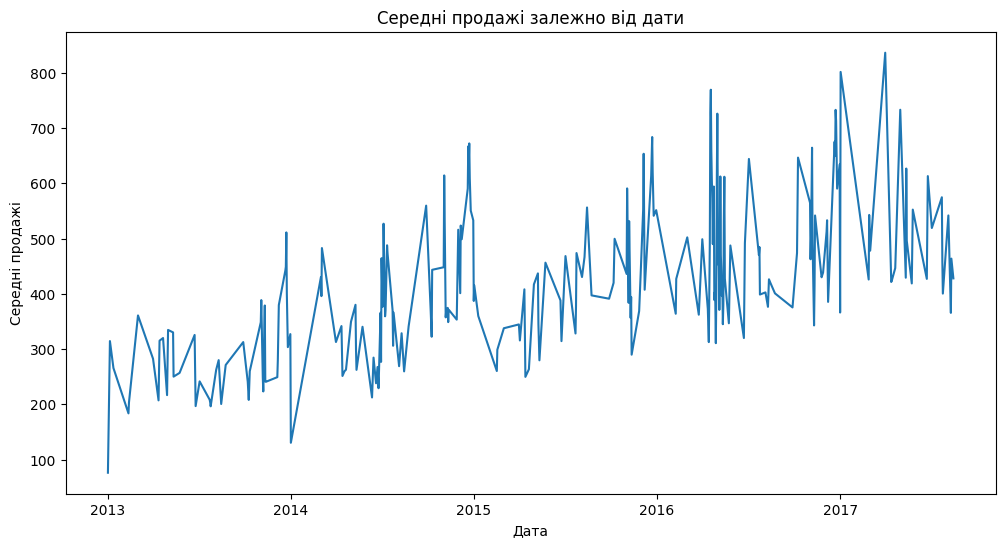

In [6]:
# Перетворення дати на datetime формат для аналізу
train_df['date'] = pd.to_datetime(train_df['date'])

# Групування за датою
date_sales = train_df.groupby('date')['sales'].mean().reset_index()

# Візуалізація
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=date_sales, x='date', y='sales')
plt.title('Середні продажі залежно від дати')
plt.xlabel('Дата')
plt.ylabel('Середні продажі')
plt.show()

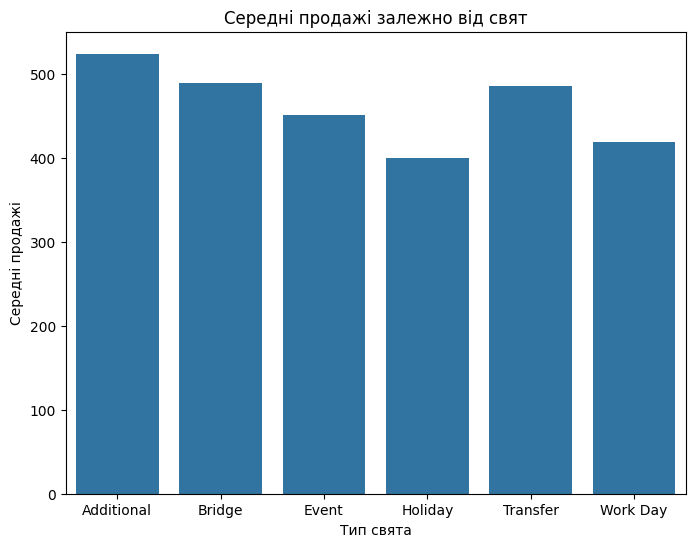

In [7]:
# Групування за святами (якщо є відповідна колонка)
holiday_sales = train_df.groupby('type_x')['sales'].mean().reset_index()

# Візуалізація
plt.figure(figsize=(8, 6))
sns.barplot(data=holiday_sales, x='type_x', y='sales')
plt.title('Середні продажі залежно від свят')
plt.xlabel('Тип свята')
plt.ylabel('Середні продажі')
plt.show()


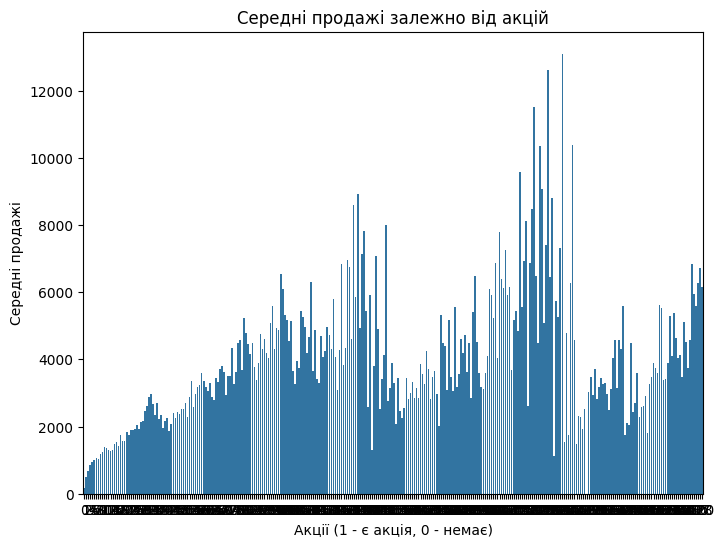

In [8]:
# Групування за акціями (onpromotion)
promotion_sales = train_df.groupby('onpromotion')['sales'].mean().reset_index()

# Візуалізація
plt.figure(figsize=(8, 6))
sns.barplot(data=promotion_sales, x='onpromotion', y='sales')
plt.title('Середні продажі залежно від акцій')
plt.xlabel('Акції (1 - є акція, 0 - немає)')
plt.ylabel('Середні продажі')
plt.show()


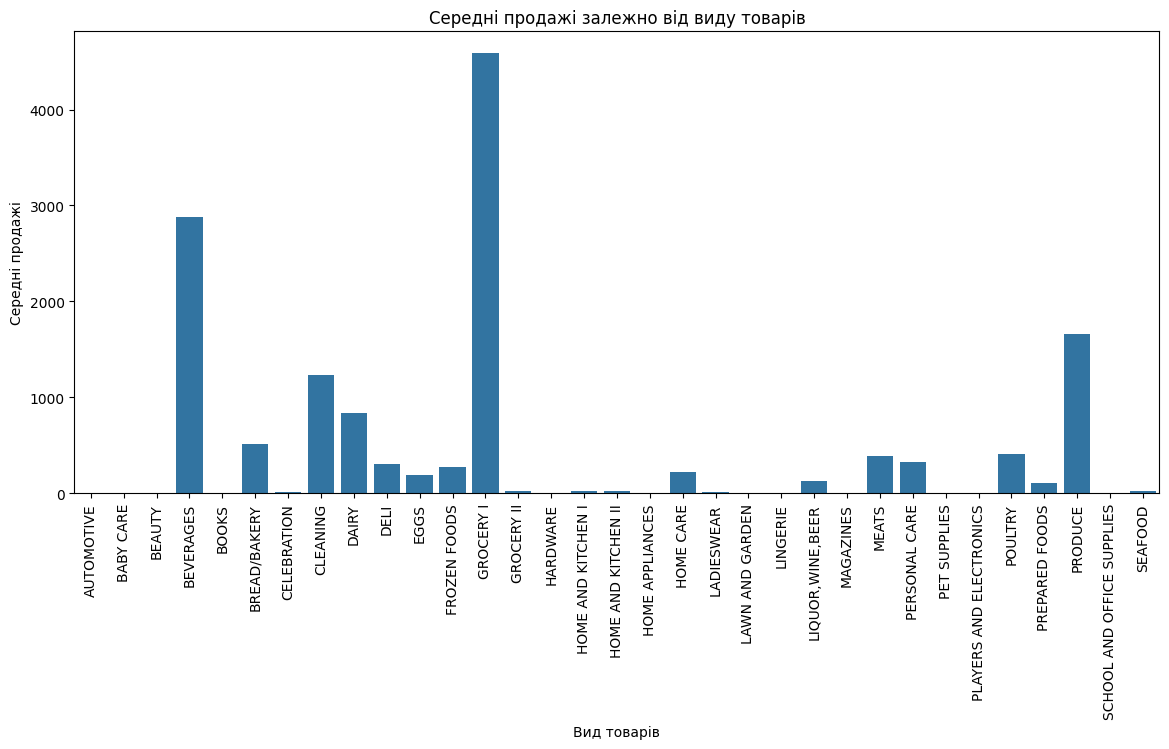

In [9]:
# Групування за видами товарів
family_sales = train_df.groupby('family')['sales'].mean().reset_index()

# Візуалізація
plt.figure(figsize=(14, 6))
sns.barplot(data=family_sales, x='family', y='sales')
plt.xticks(rotation=90)
plt.title('Середні продажі залежно від виду товарів')
plt.xlabel('Вид товарів')
plt.ylabel('Середні продажі')
plt.show()

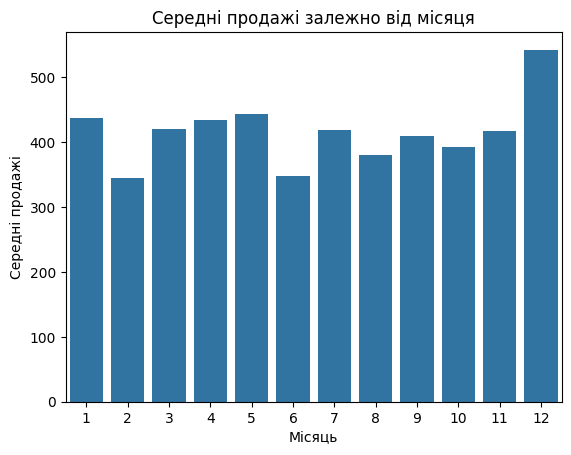

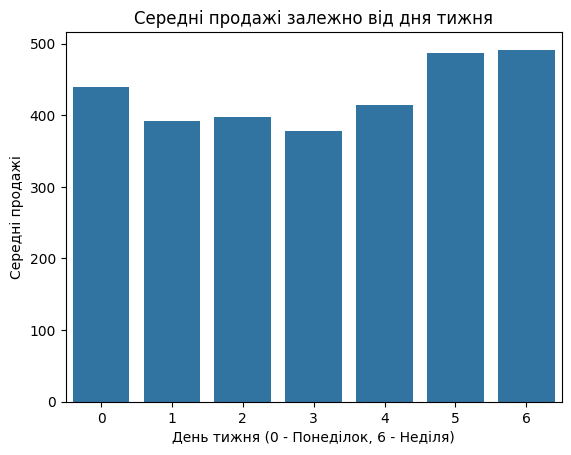

In [10]:
# Виділення місяців і днів тижня
train_df['month'] = train_df['date'].dt.month
train_df['day_of_week'] = train_df['date'].dt.dayofweek

# Групування за місяцями
monthly_sales = train_df.groupby('month')['sales'].mean().reset_index()
sns.barplot(data=monthly_sales, x='month', y='sales')
plt.title('Середні продажі залежно від місяця')
plt.xlabel('Місяць')
plt.ylabel('Середні продажі')
plt.show()

# Групування за днями тижня
weekly_sales = train_df.groupby('day_of_week')['sales'].mean().reset_index()
sns.barplot(data=weekly_sales, x='day_of_week', y='sales')
plt.title('Середні продажі залежно від дня тижня')
plt.xlabel('День тижня (0 - Понеділок, 6 - Неділя)')
plt.ylabel('Середні продажі')
plt.show()


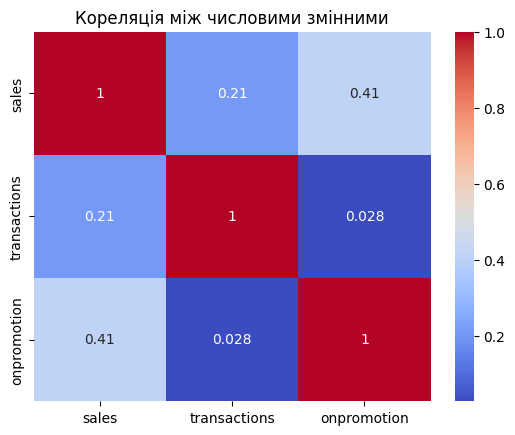

In [11]:
# Кореляційна матриця
correlation_matrix = train_df[['sales', 'transactions', 'onpromotion']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Кореляція між числовими змінними')
plt.show()

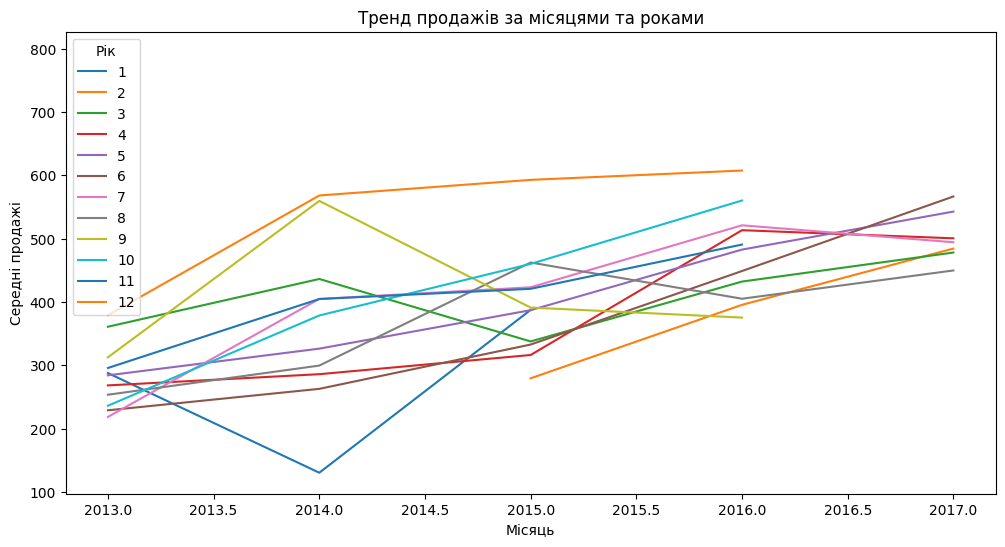

In [12]:
# Групування за місяцями та роками
train_df['year'] = train_df['date'].dt.year
monthly_trends = train_df.groupby(['year', 'month'])['sales'].mean().unstack()

# Побудова трендів за роками
monthly_trends.plot(figsize=(12, 6))
plt.title('Тренд продажів за місяцями та роками')
plt.xlabel('Місяць')
plt.ylabel('Середні продажі')
plt.legend(title='Рік')
plt.show()

In [13]:
# Extract features and target variable
X_train = train.drop(columns=['sales', 'date'])
y_train = train['sales']

y_train.fillna(y_train.mean(), inplace=True)
X_test = test

In [14]:
# Попередня обробка даних
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [15]:
# Розділення на тренувальний і валідаційний набори
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [16]:
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(96, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Оскільки це регресія, на виході один нейрон
])
model.compile(optimizer=Adam(0.005), loss='mse', metrics=['mae'])

C:\Users\Dell\PycharmProjects\lab3_kp\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Навчання моделі
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=70, batch_size=1024, verbose=1)

Epoch 1/70
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 498032.7500 - mae: 219.9516 - val_loss: 332203.0625 - val_mae: 164.9299
Epoch 2/70
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 309077.2812 - mae: 165.9292 - val_loss: 310648.6875 - val_mae: 165.9864
Epoch 3/70
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - loss: 296392.9062 - mae: 159.6040 - val_loss: 309717.9375 - val_mae: 154.0587
Epoch 4/70
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 287677.6875 - mae: 156.9366 - val_loss: 294082.8438 - val_mae: 162.2383
Epoch 5/70
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 274137.5312 - mae: 153.5547 - val_loss: 288608.4375 - val_mae: 158.5127
Epoch 6/70
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 44s 19ms/step - loss: 282663.4688 - mae: 152.8174 - val_loss: 284812.0938 - val_mae: 153.0569
Epoch 7/70
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - loss: 269578.8750 - mae: 151.7934 - val_loss: 286453.8750 - val_mae: 151.2240
Epoch 8/70
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 33s 14m

In [19]:
y_valid_pred = model.predict(X_valid)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_valid, y_valid_pred)
mse = mean_squared_error(y_valid, y_valid_pred)
rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
r2 = r2_score(y_valid, y_valid_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')

18756/18756 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step
Mean Absolute Error (MAE): 112.99614024255176
Mean Squared Error (MSE): 185037.6259747809
Root Mean Squared Error (RMSE): 430.1600004356297
R-squared (R²): 0.8511137251922118


C:\Users\Dell\PycharmProjects\lab3_kp\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
# Прогноз для тестового набору
y_test_pred = model.predict(X_test)

submission = pd.DataFrame({
    'id': test['id'],
    'sales': y_test_pred.squeeze()
})
submission.to_csv('neural_network_submission.csv', index=False)
print("Submission file has been created successfully.")

891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step
Submission file has been created successfully.


In [21]:
# Зберегти модель
model.save("Sales_model.h5") 

# # Аби завантаити модель в іншому середовищі
# from tensorflow.keras.models import load_model
# loaded_model = load_model("Sales_model.h5")

In [22]:
model.save('Sales_model_new_method.keras')